<h1>Challenge 2: Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>April 2019</i>

We decided to work directly with the images as they are provided. As we had worked with csv-files before we wanted to try a different approach to this problem. Reasoning for different decions are provided at the appropiate places through the notebook. 

## Data Exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 

### Fetching Data

#### Importing libraries

In [1]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

basepath = '/mnt/datasets/plankton/flowcam/'

#### Fetching images

In [2]:
imgFiles = extract_zip_to_memory(basepath + "imgs.zip")

#### Fetching datasets and labels

In [3]:
# datasets
nativeDF = pd.read_csv(basepath + 'features_native.csv.gz')
skimagDF = pd.read_csv(basepath + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(basepath + 'meta.csv')

#### Exploring the datasets
We do not use the "features_skimage.csv.gz" dataset. "features_native.csv.gz" are used to look at the distribution of height and width of the images. Labels from "meta.csv" is used for training of the neural network. 

In [4]:
print("Total amount of pictures in the complete dataset: ", nativeDF.shape[0])
print("Maximum width in the dataset: ", nativeDF.width.max())
print("Maximum height in the dataset: ", nativeDF.height.max())

Total amount of pictures in the complete dataset:  243610
Maximum width in the dataset:  972
Maximum height in the dataset:  739


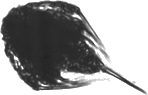

In [5]:
# display a picture
Image.open(imgFiles['imgs/32748610.jpg'])

In [6]:
print(labelsDF.loc[labelsDF["objid"] == 32748610.0].level2.values[0])

nauplii (Crustacea)


Above we can see a specimen of the "nauplii" taxonomy.

Text(90.125,0.5,'height of images')

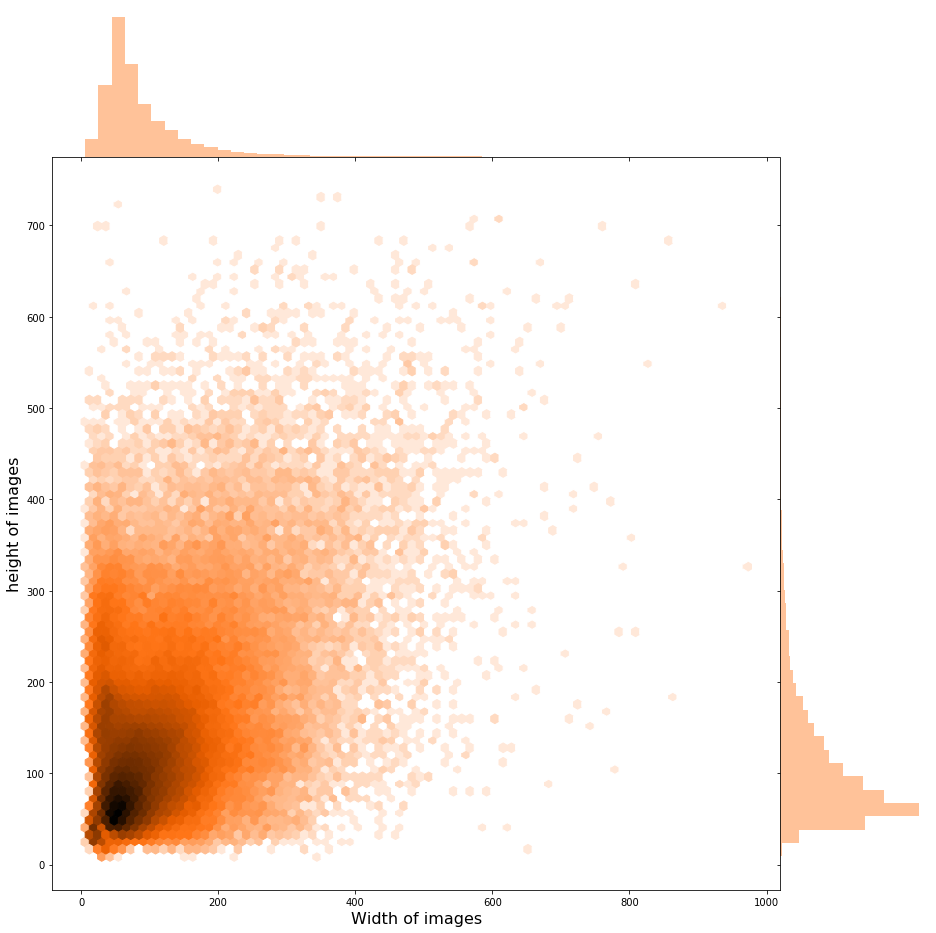

In [7]:
# Joint plot with histogram and binned scatter of the width and height of the images
cmap=plt.cm.gist_heat_r
hexmap = sns.jointplot(nativeDF.width, nativeDF.height, kind='hex', space=0, color=cmap(.3), height=13,  
                       joint_kws=dict(gridsize=80, bins="log"))
hexmap.ax_joint.set_xlabel('Width of images',  fontsize=16)
hexmap.ax_joint.set_ylabel('height of images', fontsize=16)



The above plot shows the distribution of the width and height of all the images in the dataset. We can see the majority of the images are less than 100x100 pixels (the bins used for plotting are normalized), but there are some images which are significantly bigger. The maximum width is 972 pixels and the maximum height is 739 pixels.

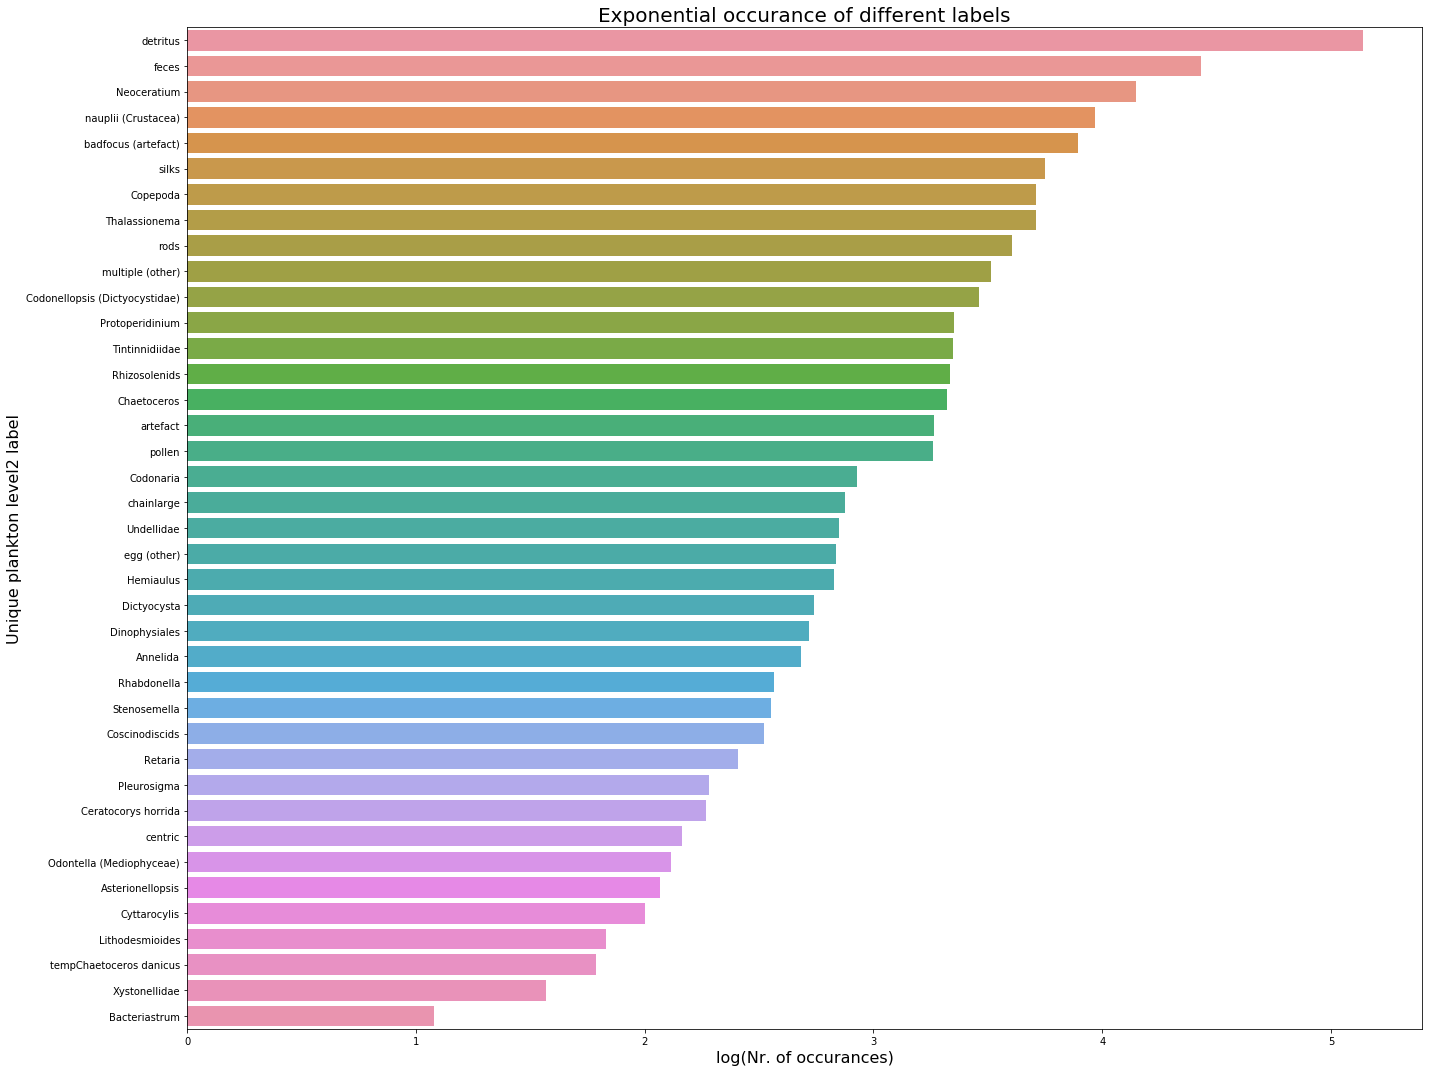

In [8]:
# Barplot
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(20,15))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))


plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=20)
plt.tight_layout()

In [9]:
unique_names = labelsDF.groupby('level2', as_index=False)['id'].count()
unique_names.sort_values(inplace=True, ascending=False, by='id')

print(unique_names.iloc[0])
print(unique_names.iloc[-1])

level2    detritus
id          138439
Name: 30, dtype: object
level2    Bacteriastrum
id                   12
Name: 2, dtype: object


The plot above shows the distribution of the different labels that the different images are assigned to. The x axis is exponential as the most numerous labels would completly dominate the plot otherwise. There is a big disparity in the number of images within different label-classes. The least represented label (Bacteriastrum) has only 12 images and the most represented label (Detritus) have 138439 images. This will make classification difficult if left unaccounted for. 

## Data Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

The images in the dataset have varied height and width. As we will use a convoluted neural network (CNN) we need all images to be of the same input size. We solve this by creating a blank 972x972 (max size and square) image. We then scale up the orignal image to the new size. Next the original is put in the middle of the blank 972x972 which works like padding of the original. Finally we scale the image down to 100x100 as we chose this as the input shape for the CNN.

One of the cons of scaling the images before padding them with white pixels is that we loose the relative size parameter between different types of plankton. The alternatives would be to scale all the images up to the greatest size of 972x972, but this would take up a lot of space in memory, or deleting images over a certain size. The problem with scaling al the images up to 972x972 is that it would greatly increase the complexity of the NN, and most likely exceed the available memory. Deleting the images above a certain size is also a viable alternative, as they are few images that exceed 500 pixels in width or height. Below we show some statistics about how many "big images" there are. 

In [10]:
w_500 = nativeDF[nativeDF['width'] >= 500]['objid'].count()
h_500 = nativeDF[nativeDF['height'] >= 500]['objid'].count()
b_500 = nativeDF[(nativeDF['width'] >= 500) & (nativeDF['height'] >= 500)]['objid'].count()
e_500 = w_500 + h_500 - b_500
print('Nr. of images with width greater than 500 pixels:', w_500)
print('Nr. of images with height greater than 500 pixels:', h_500)
print('Nr. of images with width and height greater than 500 pixels:', b_500)
print('Nr. of images with width or height greater than 500 pixels:', e_500)

unwanted_imgs = labelsDF[(nativeDF['width'] >= 500) | (nativeDF['height'] >= 500)]
print('labels-classes containing images ', unwanted_imgs['level2'].unique())

Nr. of images with width greater than 500 pixels: 294
Nr. of images with height greater than 500 pixels: 485
Nr. of images with width and height greater than 500 pixels: 66
Nr. of images with width or height greater than 500 pixels: 713
labels-classes containing images  ['silks' 'Neoceratium' 'Rhizosolenids' 'multiple (other)' 'detritus'
 'Copepoda' 'artefact' 'rods' 'feces' 'Dinophysiales' nan 'Annelida'
 'badfocus (artefact)' 'nauplii (Crustacea)']


As we can see, there are 713 images that are considered as "too big", by this metric. We will explore this more later. 

In [11]:
# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

def image_processing(path):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(path)
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

Earlier we discovered a disparity in the distribution of the different labels. This will make it more difficult for our Neural Network to predict the correct level 2 taxonomy for Plankton of the label-classes with fewer images. We attempt resolve this by generating new images for the label-classes with fewer images. We do this by transposing, rotating and flipping the original image. This way we are able to generate 8 times more data in the underrepresented label-classes.

In [12]:
# functions for handling of data

def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

In [13]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in img_keys}

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/32577145.jpg'

In [ ]:
del imgFiles

In [ ]:
def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    # Flip image up down
    img_flipped_ud = np.flip(img_np_array, 0)
    # Flip image left right
    img_flipped_lr = np.flip(img_np_array, 1)
    # Rotate image 90 degrees
    img_rot_90 = np.rot90(img_np_array, k=1)
    # Rotate image 180 degrees
    img_rot_180 = np.rot90(img_np_array, k=2)
    # Rotate image 270 degrees
    img_rot_270 = np.rot90(img_np_array, k=3) 
    # Transpose image (flip it around axis going from upper left corner to bottom right)
    img_tran_1 = np.transpose(img_np_array) 
    # Flip image around axis going from upper right corner to bottom left
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1) 
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = fetch_label(reverse_strip(object_id))
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

In [ ]:
# Actually generate more data
total_nr = 0
for label in labels_to_multiply:
    object_ids = original_objid_dict[label]
    print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
    total_nr += len(object_ids)*8
    for objid in object_ids:
        processed_imgs = generate_duplicates(objid)
print('Total nr of new images produced:', total_nr)    

In [ ]:
print('new length of images:', len(list(processed_imgs.keys())))

In [ ]:
list_labels = []
for objid in list(processed_imgs.keys()):
    list_labels.append([objid, processed_imgs[objid][1]])

labels_objid_dict = {'objid' : [element[0] for element in list_labels],
                     'label' : [element[1] for element in list_labels]}
labelDF = pd.DataFrame.from_dict(labels_objid_dict)

number_unique_names2 = labelDF.groupby('label', as_index=True)['objid'].count()
number_unique_names2.sort_values(inplace=True, ascending=False)

In [ ]:
fig = plt.figure(figsize=(30,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(y=number_unique_names2.index, x=np.log10(number_unique_names2.values), ax=ax1)
sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values), ax=ax2)

ax1.set_ylabel('Unique plankton level2 label')
ax1.set_title('log(Nr. of occurances)')
ax1.set_title('Label distribution a/ aug')

ax2.set_ylabel('Unique plankton level2 label')
ax2.set_title('log(Nr. of occurances)')
ax2.set_title('Label distribution b/ aug')
plt.tight_layout()

In [ ]:
img_files_objids = list(processed_imgs.keys())
# Shuffle order of keys
img_files_objids = random.sample(img_files_objids, len(img_files_objids))


# Divide data into trainingand test data, by keys
from sklearn.model_selection import train_test_split
test_size = 0.10
objids_train, objids_test = train_test_split(img_files_objids, test_size = test_size)

In [ ]:
# Make small test and validation set, to explore models. 
size_small_train, size_small_validation = 40000, 4000
small_objids_train = objids_train[size_small_validation:(size_small_validation + size_small_train)]
small_objids_validation = objids_test[:size_small_validation]

In [ ]:
def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    return X, y

## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

In [ ]:
# We want to label-encode the different categories so we can one-hot encode them.  
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(small_objids_train)
# test
X_test, y_test = autoloader(small_objids_validation)

# label encode target column
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape input data to account for images only being greyscale
X_train = X_train.reshape(size_small_train, 100, 100, 1)
X_test = X_test.reshape(size_small_validation, 100, 100, 1)

In [ ]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

- https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
- https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

In [ ]:
# custom metric for calculating F1 Macro Score
import keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


# Building the CNN structure 1: input -> conv(128) -> conv(32) -> flatten -> fc(40) -> softmax
# Create model---------------------------------------------------------------------------------------------
model1 = Sequential()
# Add layers
model1.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model1.add(Conv2D(32, kernel_size=3, activation='relu'))
model1.add(Flatten())
model1.add(Dense(40, activation='softmax'))

# Compile model using accuracy to measure model performance -----------------------------------------------
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model -----------------------------------------------------------------------------------------
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

## Parameter Optimisation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    